# Univariate analysis NDVI

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from pygam import LinearGAM, s, l
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image as im

In [2]:
#! pip install pygam

## 1. Modeling vegetation densities for buffer distances of 100 meters

In [3]:
# load greenspace metrics at 100m geodataframe
gdf_100 = gpd.read_file("thesis_project/output/dataframes/greenspace_metrics_100_df.json")
gdf_100.head()

,NDVI_100,Greenspace%_100,Canopy%_100,Grass%_100,Shrubs%_100,geometry
0,0.536433,0.414039,0.201814,0.097506,0.106576,POINT (377971.171 402346.176)
1,0.571965,0.551457,0.108844,0.072562,0.340136,POINT (364310.461 403435.100)
2,0.455587,0.256395,0.129252,0.092971,0.043084,POINT (369566.841 406840.228)
3,0.816160,0.942891,0.009070,0.249433,0.068027,POINT (354567.818 412168.416)
4,0.526997,0.388459,0.217687,0.061224,0.111111,POINT (388526.382 403175.927)


### 1.1. Model 1: greenspace ~ linear(NDVI)

In [4]:
# data/predictors as the NDVI_100
df_100 = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# target as Greenspace%_100
target_100 = pd.DataFrame(gdf_100, columns=['Greenspace%_100'])

# define X and Y
X = df_100
y = target_100['Greenspace%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
# Model 1
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_1 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_1.gridsearch(X_train, y_train)
uni_gam_100_1.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9998
Link Function:                     IdentityLink Log Likelihood:                                -80696.7802
Number of Samples:                         4673 AIC:                                           161399.5601
                                                AICc:                                          161399.5652
                                                GCV:                                                 0.025
                                                Scale:                                              0.0249
                                                Pseudo R-Squared:                                   0.6672
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/161998086.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_1.summary()


### 1.2. Model 2: greenspace ~ spline(NDVI)

In [6]:
# Model 2
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_2 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_2.gridsearch(X_train, y_train)
uni_gam_100_2.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.9404
Link Function:                     IdentityLink Log Likelihood:                                -88160.4417
Number of Samples:                         4673 AIC:                                           176336.7644
                                                AICc:                                          176336.7948
                                                GCV:                                                 0.023
                                                Scale:                                               0.023
                                                Pseudo R-Squared:                                   0.6936
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2437069232.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_2.summary()


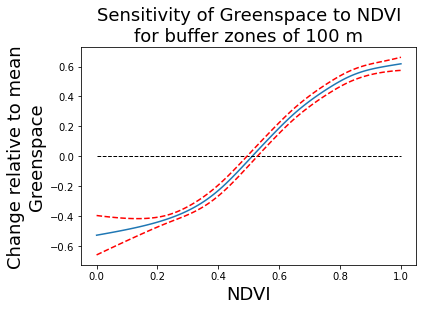

In [100]:
# plotting best greenspace_100 model
for i, term in enumerate(uni_gam_100_2.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_2.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Greenspace to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGreenspace', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_greenspace_100_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_greenspace_100_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_greenspace_100_best_plot.bmp')
    plt.show()

In [8]:
# Change in low NDVI values: how does Greenspace% increase, if NDVI changes from 0.25 to 0.35?
green_l0 = uni_gam_100_2.predict(0.25)
green_l1 = uni_gam_100_2.predict(0.35)
green_sens_low = float(green_l1 - green_l0)
print('If NDVI goes from 0.25 to 0.35, Greenspace%_100 increases by:', green_sens_low)

If NDVI goes from 0.25 to 0.35, Greenspace%_100 increases by: 0.10103401447920335


In [9]:
# Change in mid NDVI values: how does Greenspace% increase, if NDVI changes from 0.45 to 0.55?
green_m0 = uni_gam_100_2.predict(0.45)
green_m1 = uni_gam_100_2.predict(0.55)
green_sens_mid = float(green_m1 - green_m0)
print('If NDVI goes from 0.45 to 0.55, Greenspace%_100 increases by:', green_sens_mid)

If NDVI goes from 0.45 to 0.55, Greenspace%_100 increases by: 0.21570574291750838


In [10]:
# Change in high NDVI values: how does Greenspace% increase, if NDVI changes from 0.65 to 0.75?
green_h0 = uni_gam_100_2.predict(0.65)
green_h1 = uni_gam_100_2.predict(0.75)
green_sens_hig = float(green_h1 - green_h0)
print('If NDVI goes from 0.65 to 0.75, Greenspace%_100 increases by:', green_sens_hig)

If NDVI goes from 0.65 to 0.75, Greenspace%_100 increases by: 0.15325252283656332


### 1.3. Model 3: tree canopy ~ linear(NDVI)

In [11]:
# NDVI_100 as the predictor
df = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# Canopy%_100 as the target
target = pd.DataFrame(gdf_100, columns=['Canopy%_100'])

# define X and y
X = df
y = target['Canopy%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_100 = linear_model.LinearRegression()
model_100 = lm_100.fit(X_train,y_train)

In [12]:
# Model 3
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_3 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_3.gridsearch(X_train, y_train)
uni_gam_100_3.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9941
Link Function:                     IdentityLink Log Likelihood:                                -65209.7151
Number of Samples:                         4673 AIC:                                           130425.4183
                                                AICc:                                          130425.4234
                                                GCV:                                                0.0302
                                                Scale:                                              0.0302
                                                Pseudo R-Squared:                                   0.0538
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2799447770.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_3.summary()


### 1.4. Model 4: tree canopy ~ spline(NDVI)

In [13]:
# Model 4
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_4 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_4.gridsearch(X_train, y_train)
uni_gam_100_4.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.9344
Link Function:                     IdentityLink Log Likelihood:                                -70124.4863
Number of Samples:                         4673 AIC:                                           140268.8413
                                                AICc:                                          140268.8879
                                                GCV:                                                0.0284
                                                Scale:                                              0.0283
                                                Pseudo R-Squared:                                   0.1164
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/3283584014.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_4.summary()


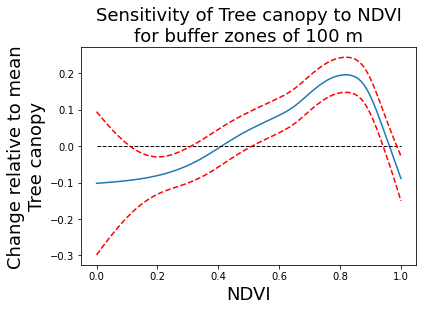

In [101]:
# plotting best canopy_100 model
for i, term in enumerate(uni_gam_100_4.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_4.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_4.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Tree canopy to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nTree canopy', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_canopy_100_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_canopy_100_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_canopy_100_best_plot.bmp')
    plt.show()

In [15]:
# Change in low NDVI values: how does canopy% increase, if NDVI changes from 0.25 to 0.35?
canopy_l0 = uni_gam_100_4.predict(0.25)
canopy_l1 = uni_gam_100_4.predict(0.35)
canopy_sens_low = float(canopy_l1 - canopy_l0)
print('If NDVI goes from 0.25 to 0.35, Canopy%_100 increases by:', canopy_sens_low)

If NDVI goes from 0.25 to 0.35, Canopy%_100 increases by: 0.037599578182805196


In [16]:
# Change in mid NDVI values: how does canopy% increase, if NDVI changes from 0.45 to 0.55?
canopy_m0 = uni_gam_100_4.predict(0.45)
canopy_m1 = uni_gam_100_4.predict(0.55)
canopy_sens_mid = float(canopy_m1 - canopy_m0)
print('If NDVI goes from 0.45 to 0.55, Canopy%_100 increases by:', canopy_sens_mid)

If NDVI goes from 0.45 to 0.55, Canopy%_100 increases by: 0.04417468408305833


In [17]:
# Change in high NDVI values: how does canopy% increase, if NDVI changes from 0.65 to 0.75?
canopy_h0 = uni_gam_100_4.predict(0.65)
canopy_h1 = uni_gam_100_4.predict(0.75)
canopy_sens_hig = float(canopy_h1 - canopy_h0)
print('If NDVI goes from 0.65 to 0.75, Canopy%_100 increases by:', canopy_sens_hig)

If NDVI goes from 0.65 to 0.75, Canopy%_100 increases by: 0.06734044235029735


### 1.5. Model 5: forbs and shrubs ~ linear(NDVI)

In [18]:
# data/predictors as the NDVI_100
df_100 = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# target as Shrubs%_100
target_100 = pd.DataFrame(gdf_100, columns=['Shrubs%_100'])

# define X and y
X = df_100
y = target_100['Shrubs%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_100 = linear_model.LinearRegression()
model_100 = lm_100.fit(X_train,y_train)

In [19]:
# Model 5
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_5 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_5.gridsearch(X_train, y_train)
uni_gam_100_5.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9994
Link Function:                     IdentityLink Log Likelihood:                                -26420.4052
Number of Samples:                         4673 AIC:                                            52846.8092
                                                AICc:                                           52846.8143
                                                GCV:                                                0.0673
                                                Scale:                                              0.0672
                                                Pseudo R-Squared:                                    0.161
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2907954286.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_5.summary()


### 1.6. Model 6: forbs and shrubs ~ spline(NDVI)

In [20]:
# Model 6
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_6 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_6.gridsearch(X_train, y_train)
uni_gam_100_6.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.2813
Link Function:                     IdentityLink Log Likelihood:                                 -26760.189
Number of Samples:                         4673 AIC:                                            53532.9406
                                                AICc:                                           53532.9602
                                                GCV:                                                0.0666
                                                Scale:                                              0.0664
                                                Pseudo R-Squared:                                   0.1717
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/201407906.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_6.summary()


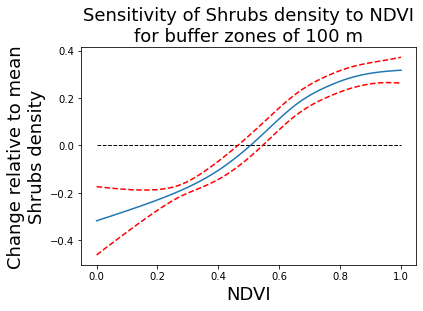

In [102]:
# plotting best model
for i, term in enumerate(uni_gam_100_6.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_6.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_6.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Shrubs density to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nShrubs density', fontsize=18)    
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_shrubs_100_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_shrubs_100_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_shrubs_100_best_plot.bmp')
    plt.show()

In [22]:
# Change in low NDVI values: how does Shrubs% increase, if NDVI changes from 0.25 to 0.35?
shrubs_l0 = uni_gam_100_6.predict(0.25)
shrubs_l1 = uni_gam_100_6.predict(0.35)
shrubs_sens_low = float(shrubs_l1 - shrubs_l0)
print('If NDVI goes from 0.25 to 0.35, Shrubs%_100 increases by:', shrubs_sens_low)

If NDVI goes from 0.25 to 0.35, Shrubs%_100 increases by: 0.06083032784864256


In [23]:
# Change in mid NDVI values: how does Shrubs% increase, if NDVI changes from 0.45 to 0.55?
shrubs_m0 = uni_gam_100_6.predict(0.45)
shrubs_m1 = uni_gam_100_6.predict(0.55)
shrubs_sens_mid = float(shrubs_m1 - shrubs_m0)
print('If NDVI goes from 0.45 to 0.55, Shrubs%_100 increases by:', shrubs_sens_mid)

If NDVI goes from 0.45 to 0.55, Shrubs%_100 increases by: 0.11102418846354661


In [24]:
# Change in high NDVI values: how does Shrubs% increase, if NDVI changes from 0.65 to 0.75?
shrubs_h0 = uni_gam_100_6.predict(0.65)
shrubs_h1 = uni_gam_100_6.predict(0.75)
shrubs_sens_hig = float(shrubs_h1 - shrubs_h0)
print('If NDVI goes from 0.65 to 0.75, Shrubs%_100 increases by:', shrubs_sens_hig)

If NDVI goes from 0.65 to 0.75, Shrubs%_100 increases by: 0.07657062431426764


### 1.7. Model 7: grass ~ linear(NDVI)

In [25]:
# NDVI_100 as the predictor
df = pd.DataFrame(gdf_100, columns=['NDVI_100'])

# Grass%_100 as the target
target = pd.DataFrame(gdf_100, columns=['Grass%_100'])

# define X and y
X = df
y = target['Grass%_100']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_100 = linear_model.LinearRegression()
model_100 = lm_100.fit(X_train,y_train)

In [26]:
# Model 7
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_7 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_100_7.gridsearch(X_train, y_train)
uni_gam_100_7.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9975
Link Function:                     IdentityLink Log Likelihood:                                 -76974.679
Number of Samples:                         4673 AIC:                                            153955.353
                                                AICc:                                          153955.3582
                                                GCV:                                                 0.026
                                                Scale:                                               0.026
                                                Pseudo R-Squared:                                   0.1439
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/822825484.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_7.summary()


### 1.8. Model 8: grass ~ spline(NDVI)

In [27]:
# Model 8
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_100_8 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_100_8.gridsearch(X_train, y_train)
uni_gam_100_8.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.9344
Link Function:                     IdentityLink Log Likelihood:                                -80600.2742
Number of Samples:                         4673 AIC:                                           161220.4172
                                                AICc:                                          161220.4638
                                                GCV:                                                 0.025
                                                Scale:                                              0.0249
                                                Pseudo R-Squared:                                   0.1814
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/227079347.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_100_8.summary()


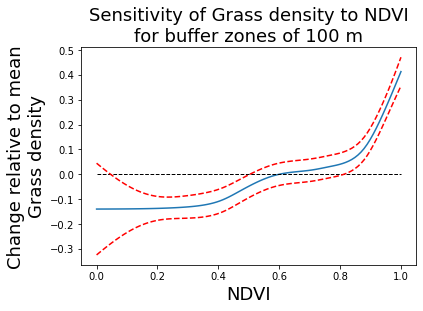

In [103]:
# plotting best grass_100 model
for i, term in enumerate(uni_gam_100_8.terms):
    if term.isintercept:
        continue

    XX = uni_gam_100_8.generate_X_grid(term=i)
    pdep, confi = uni_gam_100_8.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Grass density to NDVI\nfor buffer zones of 100 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGrass density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_grass_100_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_grass_100_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_grass_100_best_plot.bmp')
    plt.show()

In [29]:
# Change in low NDVI values: how does Grass% increase, if NDVI changes from 0.25 to 0.35?
grass_l0 = uni_gam_100_8.predict(0.25)
grass_l1 = uni_gam_100_8.predict(0.35)
grass_sens_low = float(grass_l1 - grass_l0)
print('If NDVI goes from 0.25 to 0.35, Grass%_100 increases by:', grass_sens_low)

If NDVI goes from 0.25 to 0.35, Grass%_100 increases by: 0.010868341441339038


In [30]:
# Change in mid NDVI values: how does Grass% increase, if NDVI changes from 0.45 to 0.55?
grass_m0 = uni_gam_100_8.predict(0.45)
grass_m1 = uni_gam_100_8.predict(0.55)
grass_sens_mid = float(grass_m1 - grass_m0)
print('If NDVI goes from 0.45 to 0.55, Grass%_100 increases by:', grass_sens_mid)

If NDVI goes from 0.45 to 0.55, Grass%_100 increases by: 0.06220137254354009


In [31]:
# Change in high NDVI values: how does Grass% increase, if NDVI changes from 0.65 to 0.75?
grass_h0 = uni_gam_100_8.predict(0.65)
grass_h1 = uni_gam_100_8.predict(0.75)
grass_sens_hig = float(grass_h1 - grass_h0)
print('If NDVI goes from 0.65 to 0.75, Grass%_100 increases by:', grass_sens_hig)

If NDVI goes from 0.65 to 0.75, Grass%_100 increases by: 0.017538271162339553


## 2. Modeling vegetation densities for buffer distances of 300 meters

In [32]:
# load greenspace metrics at 300m geodataframe
gdf_300 = gpd.read_file("thesis_project/output/dataframes/greenspace_metrics_300_df.json")
gdf_300.head()

,NDVI_300,Greenspace%_300,Canopy%_300,Grass%_300,Shrubs%_300,geometry
0,0.488255,0.955836,2.242873e-16,0.062290,0.421350,POINT (396607.971 420663.294)
1,0.531893,0.496460,2.145669e-01,0.128283,0.198172,POINT (357230.295 401556.298)
2,0.812246,0.932001,4.007312e-01,0.247811,0.353859,POINT (390380.102 385914.240)
3,0.949025,0.989765,4.611924e-02,0.185859,0.605270,POINT (374281.691 415010.143)
4,0.562222,0.574693,3.180540e-01,0.167677,0.148158,POINT (389574.066 388155.085)


### 2.1. Model 1: greenspace ~ linear(NDVI)

In [33]:
# data/predictors as the NDVI_300
df_300 = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# target as Greenspace%_300
target_300 = pd.DataFrame(gdf_300, columns=['Greenspace%_300'])

# define X and Y
X = df_300
y = target_300['Greenspace%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
# Model 1
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_1 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_1.gridsearch(X_train, y_train)
uni_gam_300_1.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9999
Link Function:                     IdentityLink Log Likelihood:                               -113748.4945
Number of Samples:                         4688 AIC:                                           227502.9888
                                                AICc:                                          227502.9939
                                                GCV:                                                0.0183
                                                Scale:                                              0.0183
                                                Pseudo R-Squared:                                   0.6797
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/1216624643.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_1.summary()


### 2.2. Model 2: greenspace ~ spline(NDVI)

In [35]:
# Model 2
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_2 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_2.gridsearch(X_train, y_train)
uni_gam_300_2.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6321
Link Function:                     IdentityLink Log Likelihood:                               -122150.3757
Number of Samples:                         4688 AIC:                                           244318.0154
                                                AICc:                                           244318.051
                                                GCV:                                                0.0171
                                                Scale:                                              0.0171
                                                Pseudo R-Squared:                                   0.7008
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/3283538479.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_2.summary()


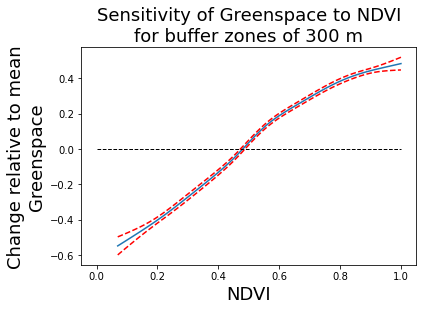

In [104]:
# plotting best greenspace_300 model
for i, term in enumerate(uni_gam_300_2.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_2.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Greenspace to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGreenspace', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_greenspace_300_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_greenspace_300_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_greenspace_300_best_plot.bmp')
    plt.show()

In [37]:
# Change in low NDVI values: how does Greenspace% increase, if NDVI changes from 0.25 to 0.35?
green_l0 = uni_gam_300_2.predict(0.25)
green_l1 = uni_gam_300_2.predict(0.35)
green_sens_low_300 = float(green_l1 - green_l0)
print('If NDVI goes from 0.25 to 0.35, Greenspace%_300 increases by:', green_sens_low_300)

If NDVI goes from 0.25 to 0.35, Greenspace%_300 increases by: 0.13612591366458804


In [38]:
# Change in mid NDVI values: how does Greenspace% increase, if NDVI changes from 0.45 to 0.55?
green_m0 = uni_gam_300_2.predict(0.45)
green_m1 = uni_gam_300_2.predict(0.55)
green_sens_mid_300 = float(green_m1 - green_m0)
print('If NDVI goes from 0.45 to 0.55, Greenspace%_300 increases by:', green_sens_mid_300)

If NDVI goes from 0.45 to 0.55, Greenspace%_300 increases by: 0.17624247464368298


In [39]:
# Change in high NDVI values: how does Greenspace% increase, if NDVI changes from 0.65 to 0.75?
green_h0 = uni_gam_300_2.predict(0.65)
green_h1 = uni_gam_300_2.predict(0.75)
green_sens_hig_300 = float(green_h1 - green_h0)
print('If NDVI goes from 0.65 to 0.75, Greenspace%_300 increases by:', green_sens_hig_300)

If NDVI goes from 0.65 to 0.75, Greenspace%_300 increases by: 0.09916766379399944


### 2.3. Model 3: tree canopy ~ linear(NDVI)

In [40]:
# NDVI_300 as the predictor
df = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# Canopy%_300 as the target
target = pd.DataFrame(gdf_300, columns=['Canopy%_300'])

# define X and y
X = df
y = target['Canopy%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_300 = linear_model.LinearRegression()
model_300 = lm_300.fit(X_train,y_train)

In [41]:
# Model 3
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_3 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_3.gridsearch(X_train, y_train)
uni_gam_300_3.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       1.992
Link Function:                     IdentityLink Log Likelihood:                               -111101.0379
Number of Samples:                         4688 AIC:                                             222208.06
                                                AICc:                                          222208.0651
                                                GCV:                                                0.0187
                                                Scale:                                              0.0187
                                                Pseudo R-Squared:                                   0.0351
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/1162806293.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_3.summary()


### 2.4. Model 4: tree canopy ~ spline(NDVI)

In [42]:
# Model 4
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_4 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_4.gridsearch(X_train, y_train)
uni_gam_300_4.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.8639
Link Function:                     IdentityLink Log Likelihood:                               -115681.2981
Number of Samples:                         4688 AIC:                                           231376.3239
                                                AICc:                                           231376.347
                                                GCV:                                                 0.018
                                                Scale:                                               0.018
                                                Pseudo R-Squared:                                   0.0719
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2529495405.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_4.summary()


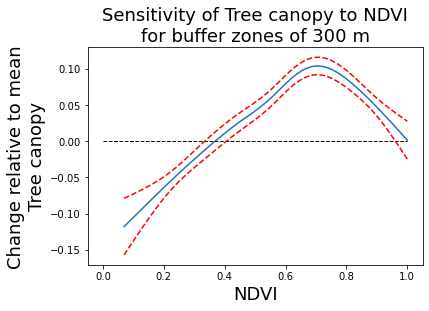

In [105]:
# plotting
for i, term in enumerate(uni_gam_300_4.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_4.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_4.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#    plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Tree canopy to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nTree canopy', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_canopy_300_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_canopy_300_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_canopy_300_best_plot.bmp')
    plt.show()

In [44]:
# Change in low NDVI values: how does Canopy% increase, if NDVI changes from 0.25 to 0.35?
canopy_l0 = uni_gam_300_4.predict(0.25)
canopy_l1 = uni_gam_300_4.predict(0.35)
canopy_sens_low_300 = float(canopy_l1 - canopy_l0)
print('If NDVI goes from 0.25 to 0.35, Canopy%_300 increases by:', canopy_sens_low_300)

If NDVI goes from 0.25 to 0.35, Canopy%_300 increases by: 0.03749582470927029


In [45]:
# Change in mid NDVI values: how does Canopy% increase, if NDVI changes from 0.45 to 0.55?
canopy_m0 = uni_gam_300_4.predict(0.45)
canopy_m1 = uni_gam_300_4.predict(0.55)
canopy_sens_mid_300 = float(canopy_m1 - canopy_m0)
print('If NDVI goes from 0.45 to 0.55, Canopy%_300 increases by:', canopy_sens_mid_300)

If NDVI goes from 0.45 to 0.55, Canopy%_300 increases by: 0.0320206722478823


In [46]:
# Change in high NDVI values: how does Canopy% increase, if NDVI changes from 0.65 to 0.75?
canopy_h0 = uni_gam_300_4.predict(0.65)
canopy_h1 = uni_gam_300_4.predict(0.75)
canopy_sens_hig_300 = float(canopy_h1 - canopy_h0)
print('If NDVI goes from 0.65 to 0.75, Canopy%_300 increases by:', canopy_sens_hig_300)

If NDVI goes from 0.65 to 0.75, Canopy%_300 increases by: 0.0028304599644339012


### 2.5. Model 5: forbs and shrubs ~ linear(NDVI)

In [47]:
# data/predictors as the NDVI_300
df_300 = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# target as Shrubs%_300
target_300 = pd.DataFrame(gdf_300, columns=['Shrubs%_300'])

# define X and y
X = df_300
y = target_300['Shrubs%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_300 = linear_model.LinearRegression()
model_300 = lm_300.fit(X_train,y_train)

In [48]:
# Model 5
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_5 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_5.gridsearch(X_train, y_train)
uni_gam_300_5.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       1.998
Link Function:                     IdentityLink Log Likelihood:                                -39594.5834
Number of Samples:                         4688 AIC:                                            79195.1628
                                                AICc:                                           79195.1679
                                                GCV:                                                0.0473
                                                Scale:                                              0.0472
                                                Pseudo R-Squared:                                   0.1814
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2500949949.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_5.summary()


### 2.6. Model 6: forbs and shrubs ~ spline(NDVI)

In [49]:
# Model 6
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_6 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_6.gridsearch(X_train, y_train)
uni_gam_300_6.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.7893
Link Function:                     IdentityLink Log Likelihood:                                 -40026.441
Number of Samples:                         4688 AIC:                                            80074.4606
                                                AICc:                                            80074.515
                                                GCV:                                                0.0469
                                                Scale:                                              0.0467
                                                Pseudo R-Squared:                                    0.192
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/1093988074.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_6.summary()


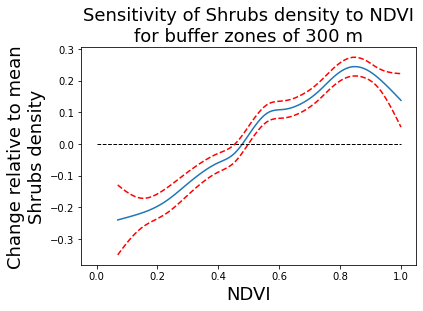

In [106]:
# plotting
for i, term in enumerate(uni_gam_300_6.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_6.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_6.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
 #   plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Shrubs density to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nShrubs density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_shrubs_300_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_shrubs_300_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_shrubs_300_best_plot.bmp')
    plt.show()

In [51]:
# Change in low NDVI values: how does shrubs% increase, if NDVI changes from 0.25 to 0.35?
shrubs_l0 = uni_gam_300_6.predict(0.25)
shrubs_l1 = uni_gam_300_6.predict(0.35)
shrubs_sens_low_300 = float(shrubs_l1 - shrubs_l0)
print('If NDVI goes from 0.25 to 0.35, shrubs%_300 increases by:', shrubs_sens_low_300)

If NDVI goes from 0.25 to 0.35, shrubs%_300 increases by: 0.07724895435371407


In [52]:
# Change in mid NDVI values: how does shrubs% increase, if NDVI changes from 0.45 to 0.55?
shrubs_m0 = uni_gam_300_6.predict(0.45)
shrubs_m1 = uni_gam_300_6.predict(0.55)
shrubs_sens_mid_300 = float(shrubs_m1 - shrubs_m0)
print('If NDVI goes from 0.45 to 0.55, shrubs%_300 increases by:', shrubs_sens_mid_300)

If NDVI goes from 0.45 to 0.55, shrubs%_300 increases by: 0.12214665619742704


In [53]:
# Change in high NDVI values: how does shrubs% increase, if NDVI changes from 0.65 to 0.75?
shrubs_h0 = uni_gam_300_6.predict(0.65)
shrubs_h1 = uni_gam_300_6.predict(0.75)
shrubs_sens_hig_300 = float(shrubs_h1 - shrubs_h0)
print('If NDVI goes from 0.65 to 0.75, shrubs%_300 increases by:', shrubs_sens_hig_300)

If NDVI goes from 0.65 to 0.75, shrubs%_300 increases by: 0.0676309094497004


### 2.7. Model 7: grass ~ linear(NDVI)

In [54]:
# NDVI_300 as the predictor
df = pd.DataFrame(gdf_300, columns=['NDVI_300'])

# Grass%_300 as the target
target = pd.DataFrame(gdf_300, columns=['Grass%_300'])

# define X and y
X = df
y = target['Grass%_300']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_300 = linear_model.LinearRegression()
model_300 = lm_300.fit(X_train,y_train)

In [55]:
# Model 7
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_7 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_300_7.gridsearch(X_train, y_train)
uni_gam_300_7.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9995
Link Function:                     IdentityLink Log Likelihood:                               -120838.6005
Number of Samples:                         4688 AIC:                                              241683.2
                                                AICc:                                          241683.2051
                                                GCV:                                                0.0173
                                                Scale:                                              0.0173
                                                Pseudo R-Squared:                                   0.2411
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/277399172.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_7.summary()


### 2.8. Model 8: grass ~ spline(NDVI)

In [56]:
# Model 8
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_300_8 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_300_8.gridsearch(X_train, y_train)
uni_gam_300_8.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.6321
Link Function:                     IdentityLink Log Likelihood:                               -121753.5413
Number of Samples:                         4688 AIC:                                           243524.3468
                                                AICc:                                          243524.3823
                                                GCV:                                                0.0172
                                                Scale:                                              0.0171
                                                Pseudo R-Squared:                                   0.2482
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/68270352.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_300_8.summary()


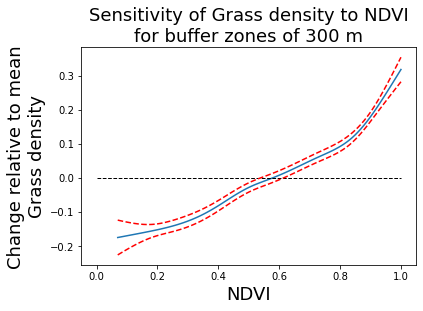

In [107]:
# plotting
for i, term in enumerate(uni_gam_300_8.terms):
    if term.isintercept:
        continue

    XX = uni_gam_300_8.generate_X_grid(term=i)
    pdep, confi = uni_gam_300_8.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#    plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Grass density to NDVI\nfor buffer zones of 300 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGrass density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_grass_300_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_grass_300_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_grass_300_best_plot.bmp')


    plt.show()

In [58]:
# Change in low NDVI values: how does Grass% increase, if NDVI changes from 0.25 to 0.35?
grass_l0 = uni_gam_300_8.predict(0.25)
grass_l1 = uni_gam_300_8.predict(0.35)
grass_sens_low_300 = float(grass_l1 - grass_l0)
print('If NDVI goes from 0.25 to 0.35, Grass%_300 increases by:', grass_sens_low_300)

If NDVI goes from 0.25 to 0.35, Grass%_300 increases by: 0.034178745396636304


In [59]:
# Change in mid NDVI values: how does Grass% increase, if NDVI changes from 0.45 to 0.55?
grass_m0 = uni_gam_300_8.predict(0.45)
grass_m1 = uni_gam_300_8.predict(0.55)
grass_sens_mid_300 = float(grass_m1 - grass_m0)
print('If NDVI goes from 0.45 to 0.55, Grass%_300 increases by:', grass_sens_mid_300)

If NDVI goes from 0.45 to 0.55, Grass%_300 increases by: 0.04354067562250222


In [60]:
# Change in hig NDVI values: how does Grass% increase, if NDVI changes from 0.65 to 0.75?
grass_h0 = uni_gam_300_8.predict(0.65)
grass_h1 = uni_gam_300_8.predict(0.75)
grass_sens_hig_300 = float(grass_h1 - grass_h0)
print('If NDVI goes from 0.65 to 0.75, Grass%_300 increases by:', grass_sens_hig_300)

If NDVI goes from 0.65 to 0.75, Grass%_300 increases by: 0.041811506570193946


## 3. Modeling vegetation densities for buffer distances of 500 meters

In [61]:
# load greenspace metrics at 500m geodataframe
gdf_500 = gpd.read_file("thesis_project/output/dataframes/greenspace_metrics_500_df.json")
gdf_500.head()

,NDVI_500,Greenspace%_500,Canopy%_500,Grass%_500,Shrubs%_500,geometry
0,0.616906,0.714233,0.509538,0.305474,0.177276,POINT (377098.736 391409.893)
1,0.535196,0.518279,0.272543,0.170375,0.244285,POINT (388776.738 395338.550)
2,0.625744,0.665035,0.458237,0.265076,0.194620,POINT (385102.497 389586.914)
3,0.869751,0.959438,0.194798,0.637881,0.401261,POINT (358860.328 409008.505)
4,0.855770,0.984456,0.180780,0.170082,0.213244,POINT (369877.609 414278.479)


### 3.1. Model 1: greenspace ~ linear(NDVI)

In [62]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Greenspace%_300 as the target
target = pd.DataFrame(gdf_500, columns=['Greenspace%_500'])

# define X and y
X = df
y = target['Greenspace%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [63]:
# Model 1
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_1 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_1.gridsearch(X_train, y_train)
uni_gam_500_1.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9998
Link Function:                     IdentityLink Log Likelihood:                                -61512.1794
Number of Samples:                         2318 AIC:                                           123030.3584
                                                AICc:                                          123030.3688
                                                GCV:                                                0.0168
                                                Scale:                                              0.0168
                                                Pseudo R-Squared:                                   0.6671
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2474993179.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_1.summary()


### 3.2. Model 2: greenspace ~ spline(NDVI)

In [64]:
# Model 2
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_2 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_2.gridsearch(X_train, y_train)
uni_gam_500_2.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.7962
Link Function:                     IdentityLink Log Likelihood:                                -65532.5424
Number of Samples:                         2318 AIC:                                           131084.6772
                                                AICc:                                          131084.7688
                                                GCV:                                                0.0159
                                                Scale:                                              0.0158
                                                Pseudo R-Squared:                                    0.688
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/3753528684.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_2.summary()


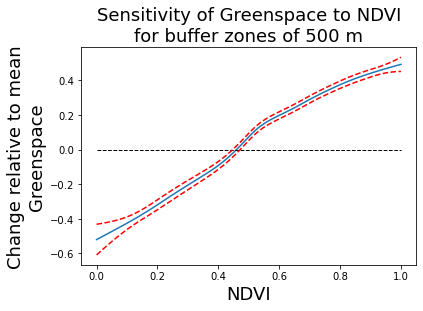

In [108]:
# plotting
for i, term in enumerate(uni_gam_500_2.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_2.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_2.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#    plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Greenspace to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGreenspace', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_greenspace_500_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_greenspace_500_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_greenspace_500_best_plot.bmp')
    plt.show()

In [66]:
# Change in low NDVI values: how does Greenspace% increase, if NDVI changes from 0.25 to 0.35?
green_l0 = uni_gam_500_2.predict(0.25)
green_l1 = uni_gam_500_2.predict(0.35)
green_sens_low_500 = float(green_l1 - green_l0)
print('If NDVI goes from 0.25 to 0.35, Greenspace%_500 increases by:', green_sens_low_500)

If NDVI goes from 0.25 to 0.35, Greenspace%_500 increases by: 0.11047695982508077


In [67]:
# Change in medium NDVI values: how does Greenspace% increase, if NDVI changes from 0.45 to 0.55?
green_m0 = uni_gam_500_2.predict(0.45)
green_m1 = uni_gam_500_2.predict(0.55)
green_sens_mid_500 = float(green_m1 - green_m0)
print('If NDVI goes from 0.45 to 0.55, Greenspace%_500 increases by:', green_sens_mid_500)

If NDVI goes from 0.45 to 0.55, Greenspace%_500 increases by: 0.1664203077071046


In [68]:
# Change in high NDVI values: how does Greenspace% increase, if NDVI changes from 0.65 to 0.75?
green_h0 = uni_gam_500_2.predict(0.65)
green_h1 = uni_gam_500_2.predict(0.75)
green_sens_hig_500 = float(green_h1 - green_h0)
print('If NDVI goes from 0.65 to 0.75, Greenspace%_500 increases by:', green_sens_hig_500)

If NDVI goes from 0.65 to 0.75, Greenspace%_500 increases by: 0.0926203126422982


### 3.3. Model 3: tree canopy ~ linear(NDVI)

In [69]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Greenspace%_300 as the target
target = pd.DataFrame(gdf_500, columns=['Canopy%_500'])

# define X and y
X = df
y = target['Canopy%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [70]:
# Model 3
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_3 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_3.gridsearch(X_train, y_train)
uni_gam_500_3.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9858
Link Function:                     IdentityLink Log Likelihood:                                 -33784.401
Number of Samples:                         2318 AIC:                                            67574.7735
                                                AICc:                                           67574.7838
                                                GCV:                                                0.0291
                                                Scale:                                              0.0291
                                                Pseudo R-Squared:                                   0.0296
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2840720071.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_3.summary()


### 3.4. Model 4: tree canopy ~ spline(NDVI)

In [71]:
# Model 4
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_4 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_4.gridsearch(X_train, y_train)
uni_gam_500_4.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       5.198
Link Function:                     IdentityLink Log Likelihood:                                -34774.5523
Number of Samples:                         2318 AIC:                                            69561.5005
                                                AICc:                                           69561.5391
                                                GCV:                                                0.0284
                                                Scale:                                              0.0283
                                                Pseudo R-Squared:                                   0.0572
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/3479331719.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_4.summary()


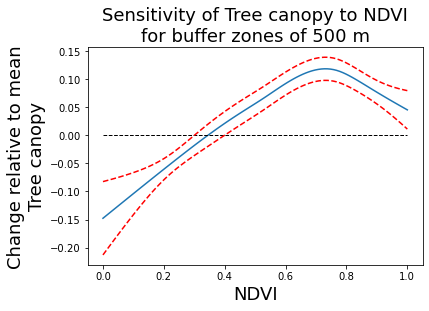

In [109]:
# plotting
for i, term in enumerate(uni_gam_500_4.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_4.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_4.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#    plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Tree canopy to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nTree canopy', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_canopy_500_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_canopy_500_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_canopy_500_best_plot.bmp')
    plt.show()

In [73]:
# Change in medium NDVI values: how does canopy% increase, if NDVI changes from 0.45 to 0.55?
canopy_m0 = uni_gam_500_4.predict(0.45)
canopy_m1 = uni_gam_500_4.predict(0.55)
canopy_sens_mid_500 = float(canopy_m1 - canopy_m0)
print('If NDVI goes from 0.45 to 0.55, canopy%_500 increases by:', canopy_sens_mid_500)

If NDVI goes from 0.45 to 0.55, canopy%_500 increases by: 0.03488364838650648


In [74]:
# Change in high NDVI values: how does canopy% increase, if NDVI changes from 0.65 to 0.75?
canopy_h0 = uni_gam_500_4.predict(0.65)
canopy_h1 = uni_gam_500_4.predict(0.75)
canopy_sens_hig_500 = float(canopy_h1 - canopy_h0)
print('If NDVI goes from 0.65 to 0.75, canopy%_500 increases by:', canopy_sens_hig_500)

If NDVI goes from 0.65 to 0.75, canopy%_500 increases by: 0.01057659406173278


In [75]:
# Change in low NDVI values: how does Canopy% increase, if NDVI changes from 0.25 to 0.35?
canopy_l0 = uni_gam_500_4.predict(0.25)
canopy_l1 = uni_gam_500_4.predict(0.35)
canopy_sens_low_500 = float(canopy_l1 - canopy_l0)
print('If NDVI goes from 0.25 to 0.35, canopy%_500 increases by:', canopy_sens_low_500)

If NDVI goes from 0.25 to 0.35, canopy%_500 increases by: 0.04109111787259234


### 3.5. Model 5: forbs and shrubs ~ linear(NDVI)

In [76]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Shrubs%_500 as the target
target = pd.DataFrame(gdf_500, columns=['Shrubs%_500'])

# define X and y
X = df
y = target['Shrubs%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [77]:
# Model 5
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_5 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_5.gridsearch(X_train, y_train)
uni_gam_500_5.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9964
Link Function:                     IdentityLink Log Likelihood:                                -23000.5644
Number of Samples:                         2318 AIC:                                            46007.1216
                                                AICc:                                            46007.132
                                                GCV:                                                 0.041
                                                Scale:                                               0.041
                                                Pseudo R-Squared:                                   0.1673
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/405054797.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_5.summary()


### 3.6. Model 6: forbs and shrubs ~ spline(NDVI)

In [78]:
# Model 6
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_6 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_6.gridsearch(X_train, y_train)
uni_gam_500_6.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.7962
Link Function:                     IdentityLink Log Likelihood:                                -23221.4333
Number of Samples:                         2318 AIC:                                            46462.4589
                                                AICc:                                           46462.5506
                                                GCV:                                                0.0408
                                                Scale:                                              0.0405
                                                Pseudo R-Squared:                                   0.1794
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2335926396.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_6.summary()


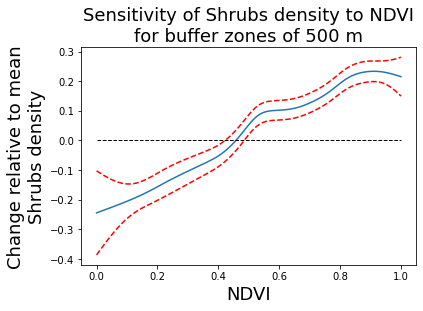

In [110]:
# plotting
for i, term in enumerate(uni_gam_500_6.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_6.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_6.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#    plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Shrubs density to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nShrubs density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_shrubs_500_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_shrubs_500_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_shrubs_500_best_plot.bmp')
    plt.show()

In [80]:
# Change in low NDVI values: how does shrubs% increase, if NDVI changes from 0.25 to 0.35?
shrubs_l0 = uni_gam_500_6.predict(0.25)
shrubs_l1 = uni_gam_500_6.predict(0.35)
shrubs_sens_low_500 = float(shrubs_l1 - shrubs_l0)
print('If NDVI goes from 0.25 to 0.35, shrubs%_500 increases by:', shrubs_sens_low_500)

If NDVI goes from 0.25 to 0.35, shrubs%_500 increases by: 0.04947840922372468


In [81]:
# Change in medium NDVI values: how does shrubs% increase, if NDVI changes from 0.45 to 0.55?
shrubs_m0 = uni_gam_500_6.predict(0.45)
shrubs_m1 = uni_gam_500_6.predict(0.55)
shrubs_sens_mid_500 = float(shrubs_m1 - shrubs_m0)
print('If NDVI goes from 0.45 to 0.55, shrubs%_500 increases by:', shrubs_sens_mid_500)

If NDVI goes from 0.45 to 0.55, shrubs%_500 increases by: 0.10366540398313567


In [82]:
# Change in high NDVI values: how does shrubs% increase, if NDVI changes from 0.65 to 0.75?
shrubs_h0 = uni_gam_500_6.predict(0.65)
shrubs_h1 = uni_gam_500_6.predict(0.75)
shrubs_sens_hig_500 = float(shrubs_h1 - shrubs_h0)
print('If NDVI goes from 0.65 to 0.75, shrubs%_500 increases by:', shrubs_sens_hig_500)

If NDVI goes from 0.65 to 0.75, shrubs%_500 increases by: 0.04532026594024574


### 3.7. Model 7: grass ~ linear(NDVI)

In [83]:
# NDVI_500 as the predictor
df = pd.DataFrame(gdf_500, columns=['NDVI_500'])

# Grass%_500 as the target
target = pd.DataFrame(gdf_500, columns=['Grass%_500'])

# define X and y
X = df
y = target['Grass%_500']

# split independent and dependent variables into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# fit the linear model
lm_500 = linear_model.LinearRegression()
model_500 = lm_500.fit(X_train,y_train)

In [84]:
# Model 7
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_7 = LinearGAM(l(0)).fit(X_train, y_train)

uni_gam_500_7.gridsearch(X_train, y_train)
uni_gam_500_7.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      1.9991
Link Function:                     IdentityLink Log Likelihood:                                -66669.8721
Number of Samples:                         2318 AIC:                                           133345.7424
                                                AICc:                                          133345.7528
                                                GCV:                                                0.0156
                                                Scale:                                              0.0156
                                                Pseudo R-Squared:                                   0.3035
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/972376635.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_7.summary()


### 3.8. Model 8: grass ~ spline(NDVI)

In [85]:
# Model 8
warnings.filterwarnings("ignore", category=RuntimeWarning)
uni_gam_500_8 = LinearGAM(s(0)).fit(X_train, y_train)

uni_gam_500_8.gridsearch(X_train, y_train)
uni_gam_500_8.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.9675
Link Function:                     IdentityLink Log Likelihood:                                -66656.3929
Number of Samples:                         2318 AIC:                                           133322.7208
                                                AICc:                                          133322.7464
                                                GCV:                                                0.0156
                                                Scale:                                              0.0156
                                                Pseudo R-Squared:                                   0.3046
Feature Function                  Lam

/var/folders/6g/kgz5rml118s6lqw25w5sv5mr0000gn/T/ipykernel_15598/2750512757.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  uni_gam_500_8.summary()


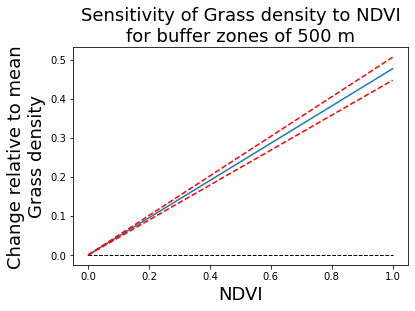

In [111]:
# plotting
for i, term in enumerate(uni_gam_500_7.terms):
    if term.isintercept:
        continue

    XX = uni_gam_500_7.generate_X_grid(term=i)
    pdep, confi = uni_gam_500_7.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.hlines(y=0, xmin=0, xmax=1, linewidth=1, color='black', linestyle='--')
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
#    plt.ylim(-0.5, 0.5)
    # set title, xlabel and ylabel
    plt.title('Sensitivity of Grass density to NDVI\nfor buffer zones of 500 m', fontsize=18)
    plt.xlabel('NDVI', fontsize=18)
    plt.ylabel('Change relative to mean\nGrass density', fontsize=18)
    # save the figure
    plt.savefig('thesis_project/visualizations/modelling/univariate/gam_grass_500_best_plot.png', dpi=300, bbox_inches='tight')
    im.open('thesis_project/visualizations/modelling/univariate/gam_grass_500_best_plot.png').save('thesis_project/visualizations/modelling/univariate/gam_grass_500_best_plot.bmp')
    plt.show()

In [87]:
# Change in low NDVI values: how does grass% increase, if NDVI changes from 0.25 to 0.35?
grass_l0 = uni_gam_500_7.predict(0.25)
grass_l1 = uni_gam_500_7.predict(0.35)
grass_sens_low_500 = float(grass_l1 - grass_l0)
print('If NDVI goes from 0.25 to 0.35, grass%_500 increases by:', grass_sens_low_500)

If NDVI goes from 0.25 to 0.35, grass%_500 increases by: 0.04764887307185422


In [88]:
# Change in medium NDVI values: how does grass% increase, if NDVI changes from 0.45 to 0.55?
grass_m0 = uni_gam_500_7.predict(0.45)
grass_m1 = uni_gam_500_7.predict(0.55)
grass_sens_mid_500 = float(grass_m1 - grass_m0)
print('If NDVI goes from 0.45 to 0.55, grass%_500 increases by:', grass_sens_mid_500)

If NDVI goes from 0.45 to 0.55, grass%_500 increases by: 0.04764887307185425


In [89]:
# Change in high NDVI values: how does grass% increase, if NDVI changes from 0.65 to 0.75?
grass_h0 = uni_gam_500_7.predict(0.65)
grass_h1 = uni_gam_500_7.predict(0.75)
grass_sens_hig_500 = float(grass_h1 - grass_h0)
print('If NDVI goes from 0.65 to 0.75, grass%_500 increases by:', grass_sens_hig_500)

If NDVI goes from 0.65 to 0.75, grass%_500 increases by: 0.04764887307185428


## 4. Prediction sensitivity analysis

### 4.1. Sensitivity of vegetation types to increments in mean NDVI for a buffer zone of 100 m

In [90]:
# vegetation metrics sensitivity to changes in NDVI
data_100 = {'Increment in mean NDVI': ['Low-range (0.25 to 0.35)', 'Mid-range (0.45 to 0.55)', 'High-range (0.65 to 0.75)'], 
        'Greenspace%_100': [green_sens_low, green_sens_mid, green_sens_hig],
        'Canopy%_100': [canopy_sens_low, canopy_sens_mid, canopy_sens_hig], 
        'Shrubs%_100': [shrubs_sens_low, shrubs_sens_mid, shrubs_sens_hig],
        'Grass%_100': [grass_sens_low, grass_sens_mid, grass_sens_hig]}  
  
# create DataFrame  
df_sens_100 = pd.DataFrame(data_100)
df_sens_100 = df_sens_100.round(5)
df_sens_100.head()

,Increment in mean NDVI,Greenspace%_100,Canopy%_100,Shrubs%_100,Grass%_100
0,Low-range (0.25 to 0.35),0.10103,0.03760,0.06083,0.01087
1,Mid-range (0.45 to 0.55),0.21571,0.04417,0.11102,0.06220
2,High-range (0.65 to 0.75),0.15325,0.06734,0.07657,0.01754


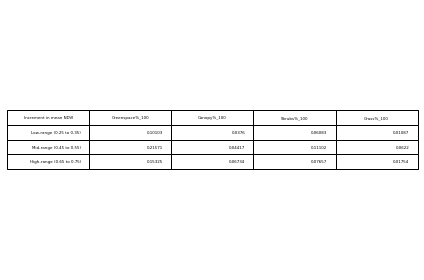

In [91]:
# plotting
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_sens_100.values, colLabels=df_sens_100.columns, loc='center')

fig.tight_layout()

# save the figure
plt.savefig('thesis_project/visualizations/modelling/univariate/sensitivity_100_table.png', dpi=300, bbox_inches='tight')

plt.show()

### 4.2. Sensitivity of vegetation types to increments in mean NDVI for a buffer zone of 300 m

In [92]:
# vegetation metrics sensitivity to changes in NDVI
data_300 = {'Increment in mean NDVI': ['Low-range (0.25 to 0.35)', 'Mid-range (0.45 to 0.55)', 'High-range (0.65 to 0.75)'], 
        'Greenspace%_300': [green_sens_low_300, green_sens_mid_300, green_sens_hig_300],
        'Canopy%_300': [canopy_sens_low_300, canopy_sens_mid_300, canopy_sens_hig_300], 
        'Shrubs%_300': [shrubs_sens_low_300, shrubs_sens_mid_300, shrubs_sens_hig_300],
        'Grass%_300': [grass_sens_low_300, grass_sens_mid_300, grass_sens_hig_300]}  
  
# create DataFrame  
df_sens_300 = pd.DataFrame(data_300)
df_sens_300 = df_sens_300.round(4)
df_sens_300.head()

,Increment in mean NDVI,Greenspace%_300,Canopy%_300,Shrubs%_300,Grass%_300
0,Low-range (0.25 to 0.35),0.1361,0.0375,0.0772,0.0342
1,Mid-range (0.45 to 0.55),0.1762,0.0320,0.1221,0.0435
2,High-range (0.65 to 0.75),0.0992,0.0028,0.0676,0.0418


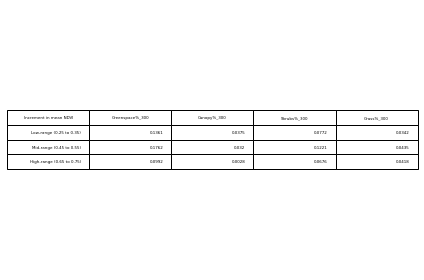

In [93]:
# plotting
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_sens_300.values, colLabels=df_sens_300.columns, loc='center')

fig.tight_layout()

# save the figure
plt.savefig('thesis_project/visualizations/modelling/univariate/sensitivity_300_table.png', dpi=300, bbox_inches='tight')

plt.show()

### 4.3. Sensitivity of vegetation types to increments in mean NDVI for a buffer zone of 500 m

In [94]:
# vegetation metrics sensitivity to changes in NDVI
data_500 = {'Increment in mean NDVI': ['Low-range (0.25 to 0.35)', 'Mid-range (0.45 to 0.55)', 'High-range (0.65 to 0.75)'], 
        'Greenspace%_500': [green_sens_low_500, green_sens_mid_500, green_sens_hig_500],
        'Canopy%_500': [canopy_sens_low_500, canopy_sens_mid_500, canopy_sens_hig_500], 
        'Shrubs%_500': [shrubs_sens_low_500, shrubs_sens_mid_500, shrubs_sens_hig_500],
        'Grass%_500': [grass_sens_low_500, grass_sens_mid_500, grass_sens_hig_500]}  
  
# create DataFrame  
df_sens_500 = pd.DataFrame(data_500)
df_sens_500 = df_sens_500.round(4)
df_sens_500.head()

,Increment in mean NDVI,Greenspace%_500,Canopy%_500,Shrubs%_500,Grass%_500
0,Low-range (0.25 to 0.35),0.1105,0.0411,0.0495,0.0476
1,Mid-range (0.45 to 0.55),0.1664,0.0349,0.1037,0.0476
2,High-range (0.65 to 0.75),0.0926,0.0106,0.0453,0.0476


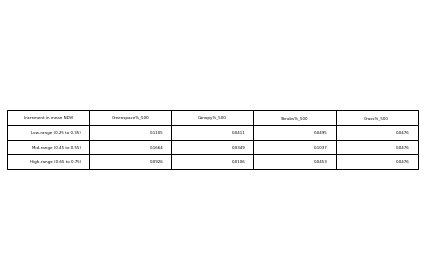

In [95]:
# plotting
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df_sens_500.values, colLabels=df_sens_500.columns, loc='center')

fig.tight_layout()

# save the figure
plt.savefig('thesis_project/visualizations/modelling/univariate/sensitivity_500_table.png', dpi=300, bbox_inches='tight')

plt.show()